## ASEN6008 HW4

# Imports

In [2]:
import numpy as np
import astro_constants
import propagators
import imd
import matplotlib.pyplot as plt

# 1

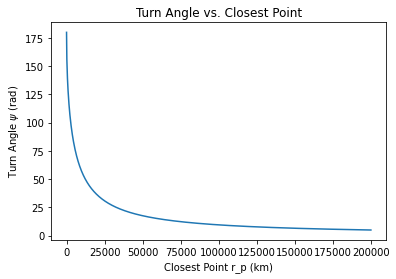

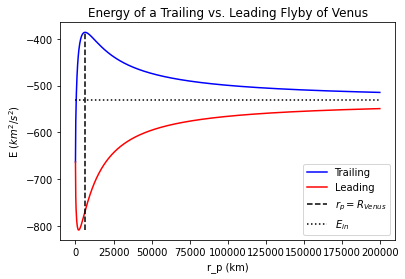

In [18]:
muE = astro_constants.MU_EARTH_KM
muS = astro_constants.MU_SUN_KM
muV = astro_constants.MU_VENUS_KM
rV = astro_constants.R_VENUS_KM

#givens
v_sc_vec = np.array([[-10.8559, -35.9372]]).transpose() #km/s, spacecraft rel to sun
v_v_vec = np.array([[-15.1945, -31.7927]]).transpose() #km/s, Venus rel to sun
r_v_vec = np.array([[-96948447.3751, 46106976.1901]]).transpose() #km

#get the v_inf in and energy
v_inf_in = v_sc_vec - v_v_vec
v_inf = np.linalg.norm(v_inf_in)
E = np.linalg.norm(v_sc_vec)**2/2-muS/np.linalg.norm(r_v_vec)

#get the turn angle with a varying rp
rp = np.linspace(0,200e3,int(1e3))
rho = np.arccos(1./(1+(v_inf**2*rp)/muV))
psis = np.pi - 2*rho

#plot psi v rp
plt.figure()
plt.plot(rp,np.rad2deg(psis))
plt.xlabel('Closest Point r_p (km)')
plt.ylabel(r'Turn Angle $\psi$ (rad)')
plt.title('Turn Angle vs. Closest Point')
plt.grid

#get the v_inf_out
E_trail = []
E_lead = []
for psi in psis:
    trail_mat = np.array([[np.cos(-psi),-np.sin(-psi)], [np.sin(-psi),np.cos(-psi)]])
    lead_mat = np.array([[np.cos(psi),-np.sin(psi)],[np.sin(psi),np.cos(psi)]]) 
    v_inf_out_trail = trail_mat @ v_inf_in
    v_out_trail = v_inf_out_trail+v_v_vec
    E_trail.append(np.linalg.norm(v_out_trail)**2/2-muS/np.linalg.norm(r_v_vec))
    v_inf_out_lead = lead_mat @ v_inf_in
    v_out_lead = v_v_vec+v_inf_out_lead
    E_lead.append(np.linalg.norm(v_out_lead)**2/2-muS/np.linalg.norm(r_v_vec))


#plot the two
plt.figure()
plt.plot(rp,E_trail,color='b',label='Trailing')
plt.plot(rp,E_lead,color='r', label='Leading')
plt.plot([rV,rV],[min(E_trail + E_lead),max(E_trail+E_lead)],color='k',linestyle='--', label=r'$r_p=R_{Venus}$')
plt.plot([min(rp),max(rp)],[E,E],color='k',linestyle=':', label=r'$E_{in}$')
plt.xlabel('r_p (km)')
plt.ylabel(r'E ($km^2/s^2$)')
plt.title('Energy of a Trailing vs. Leading Flyby of Venus')
plt.legend()
plt.grid
plt.show()

# 2

In [19]:
#givens
v_inf_in = np.array([[-5.19425, 5.19424, -5.19425]]).transpose() #km/s
v_inf_out = np.array([[-8.58481, 1.17067, -2.42304]]).transpose() #km/s

#get the psi and rp
v_inf = np.linalg.norm(v_inf_in)
psi = np.arccos(np.dot(v_inf_in.transpose(),v_inf_out)/v_inf**2)
psi_deg = np.rad2deg(psi)
rp = muE/v_inf**2 * (1/np.cos((np.pi-psi)/2) - 1)

#get the B_vec info unp.sing the v_infs
hhat = np.cross(v_inf_in,v_inf_out, axisa=0, axisb=0).transpose()/np.linalg.norm(np.cross(v_inf_in,v_inf_out, axisa=0, axisb=0))
Shat = v_inf_in/v_inf
khat = np.array([[0,0,1]]).transpose()
That = np.cross(Shat,khat, axisa=0, axisb=0).transpose()/np.linalg.norm(np.cross(Shat,khat, axisa=0, axisb=0))
Rhat = np.cross(Shat,That, axisa=0, axisb=0).transpose()
Bhat = np.cross(Shat,hhat, axisa=0, axisb=0).transpose()
b = muE/v_inf**2 * np.sqrt((1+v_inf**2*rp/muE)**2 - 1)
B = b*Bhat
Bt = np.dot(B.transpose(),That)
Br = np.dot(B.transpose(),Rhat)
theta_rad = np.arccos(np.dot(Bhat.transpose(),That)).item()
theta_deg = np.rad2deg(theta_rad)
print(f'\N{GREEK SMALL LETTER THETA}:\t{theta_deg:.3f}')

θ:	20.922


# 3

In [20]:
#state the dates
E_launch_date = 2447807.5
V_fly_date = 2447932.5
E_fly1_date = 2448235.5


#use the dates given for everything and find their positions
E_launch_pos,_ = imd.Ephem('Earth', E_launch_date)
V_fly_pos,V_fly_vel = imd.Ephem('Venus', V_fly_date)
E_fly1_pos, _ = imd.Ephem('Earth', E_fly1_date)


#find the velocities at each point of the orbit(s)
E_launch_vel, V_fly_vel1, *_ = imd.ls(E_launch_pos, V_fly_pos, V_fly_date-E_launch_date)
V_fly_vel2, E_fly1_vel1, *_ = imd.ls(V_fly_pos, E_fly1_pos, E_fly1_date-V_fly_date)

#get the v_inf of both sides
v_inf_in_vec = V_fly_vel1 - V_fly_vel
v_inf_in = np.linalg.norm(v_inf_in_vec)
v_inf_out_vec = V_fly_vel2 - V_fly_vel
v_inf_out = np.linalg.norm(v_inf_out_vec)

#compute the rp needed to make this happen
v_inf = (v_inf_out+v_inf_in)/2
psi = (np.arccos(np.dot(v_inf_in_vec.transpose(), v_inf_out_vec)/(v_inf_in*v_inf_out))).item()
rho = (np.pi-psi)/2
rp = (muV - muV*np.cos(rho))/(v_inf**2*np.cos(rho))
alt = rp - rV
print(f'Altitude:\t\t{alt} km')

#find the difference in v_inf
print(f'V_inf_in:\t\t{v_inf_in:.3f} km/s')
print(f'V_inf_out:\t\t{v_inf_out:.3f} km/s')
print(f'V_inf_diff:\t\t{v_inf_out-v_inf_in:.3f} km/s')

#Energy before and after the flyby
E_in = np.linalg.norm(V_fly_vel1)**2/2-muS/np.linalg.norm(V_fly_pos)
E_out = np.linalg.norm(V_fly_vel2)**2/2-muS/np.linalg.norm(V_fly_pos)
E_diff = E_out - E_in
print(f'Energy Difference:\t{E_diff:.3f}')

Altitude:		12819.726701950949 km
V_inf_in:		6.222 km/s
V_inf_out:		6.223 km/s
V_inf_diff:		0.001 km/s
Energy Difference:	80.165
